In [1]:
%%capture
!rm -rf data/*
!unzip data.zip -d data/
!pip install --no-cache-dir pyldavis
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn
import pickle
%matplotlib inline

# Topic Modeling in Python

In Lisa Rhody's article, "Topic Modeling and Figurative Language", she uses LDA topic modeling to look at ekphrasis poetry. She argues that ekphrasis poetry is particulary well-suited to an LDA analysis because of the assumption of a previously existing set of topics. She's able to extract a number of topics, each constituted of a set of words and probabilities. While we don't have Rhody's corpus, we can use this technique on any large text corpus. We'll use a corpus of novels curated by Andrew Piper.

---

## Corpus Description
We'll look at an English-language subset of Andrew Piper's novel corpus, totaling 150 novels by British and American authors spanning the years 1771-1930. These texts are each in a separate plaintext file in our `data` folder. Metadata is contained in a spreadsheet distributed with the novel files by the [txtLAB](https://txtlab.org/) at McGill.

The metadata provided describes the corpus that exists as `.txt` files. So let's first read in the metadata:

In [2]:
metadata_tb = Table.read_table('data/txtlab_Novel150_English.csv')
metadata_tb.show(5)

filename,id,language,date,author,title,gender,person,length
"EN_1771_Mackenzie,Henry_TheManofFeeling_Novel.txt",151,English,1771,"Mackenzie,Henry",TheManofFeeling,male,first,36458
"EN_1771_Smollett,Tobias_TheExpedictionofHenryClinker_Nov ...",152,English,1771,"Smollett,Tobias",TheExpedictionofHenryClinker,male,first,148261
"EN_1778_Burney,Fanny_Evelina_Novel.txt",153,English,1778,"Burney,Fanny",Evelina,female,first,154168
"EN_1782_Burney,Fanny_Cecilia_Novel.txt",154,English,1782,"Burney,Fanny",Cecilia,female,third,328981
"EN_1786_Beckford,William_Vathek_Novel.txt",155,English,1786,"Beckford,William",Vathek,male,third,36077


Before we go anywhere, let's randomly shuffle the rows so that we don't have them ordered by dates or anything else:

In [3]:
np.random.seed(0)
metadata_tb = Table.from_df(metadata_tb.to_df().sample(frac=1))
metadata_tb.show(5)

filename,id,language,date,author,title,gender,person,length
"EN_1900_Dreiser,Theodore_SisterCarrie_Novel.txt",265,English,1900,"Dreiser,Theodore",SisterCarrie,male,third,156048
"EN_1853_Stowe,HarrietBeecher_UncleTom'sCabin_Novel.txt",213,English,1853,"Stowe,HarrietBeecher",UncleTom'sCabin,female,third,180498
"EN_1820_Scott,Walter_Ivanhoe_Novel.txt",184,English,1820,"Scott,Walter",Ivanhoe,male,third,175069
"EN_1895_Crane,Stephen_TheRedBadgeofCourage_Novel.txt",258,English,1895,"Crane,Stephen",TheRedBadgeofCourage,male,third,46049
"EN_1794_Godwin,William_CalebWilliams_Novel.txt",158,English,1794,"Godwin,William",CalebWilliams,male,first,143832


We can see the column variables we have in the metadata with the `.labels` attribute:

In [4]:
metadata_tb.labels

('filename',
 'id',
 'language',
 'date',
 'author',
 'title',
 'gender',
 'person',
 'length')

To clarify:
<ol><li>`filename`: Name of file on disk</li>
<li>`id`: Unique ID in Piper corpus</li>
<li>`language`: Language of novel</li>
<li>`date`: Initial publication date</li>
<li>`author`: Author's name </li>
<li>`title`: Title of novel</li>
<li>`gender`: Authorial gender</li>
<li>`person`: Textual perspective</li>
<li>`length`: Number of tokens in novel</li></ol>

We see a list of `filename`s in the table, these map into a folder we have called `txtlab_Novel150_English`:

In [5]:
!ls data/txtlab_Novel150_English/

EN_1771_Mackenzie,Henry_TheManofFeeling_Novel.txt
EN_1771_Smollett,Tobias_TheExpedictionofHenryClinker_Novel.txt
EN_1778_Burney,Fanny_Evelina_Novel.txt
EN_1782_Burney,Fanny_Cecilia_Novel.txt
EN_1786_Beckford,William_Vathek_Novel.txt
EN_1788_Wollstonecraft,Mary_Mary_Novel.txt
EN_1790_Radcliffe,Ann_ASicilianRomance_Novel.txt
EN_1794_Godwin,William_CalebWilliams_Novel.txt
EN_1794_Radcliffe,Ann_TheMysteriesofUdolpho_Novel.txt
EN_1794_Rowson,Susanna_CharlotteTemple_Novel.txt
EN_1795_Lewis,Matthew_TheMonk_Novel.txt
EN_1796_Bonhote,Elizabeth_BungayCastle_Novel.txt
EN_1796_Burney,Fanny_Camilla_Novel.txt
EN_1796_Hays,Mary_EmmaCourtney_Novel.txt
EN_1797_Foster,HannahWebster_TheCoquette_Novel.txt
EN_1798_Brown,CharlesBrockden_Wieland_Novel.txt
EN_1798_Wollstonecraft,Mary_Maria_Novel.txt
EN_1799_Brown,CharlesBrockden_ArthurMervyn_Novel.txt
EN_1800_Edgeworth,Maria_CastleRackrent_Novel.txt
EN_1801_Edgeworth,Maria_Belinda_Novel.txt
EN_1804_Opie,Amelia_AdelineMowbray_Novel.txt
EN_1805_Lewis,Matthew_Th

We can then read in the full text for each novel by iterating through the column, reading each file and appending the string to our `novel_list`:

In [6]:
# create empty list, entries will be list of tokens from each novel
novel_list = []

# iterate through filenames in metadata table
for filename in metadata_tb['filename']:
    
    # read in novel text as single string
    with open('data/txtlab_Novel150_English/'+filename, 'r') as f:
        novel = f.read()
    
    # clean up (no titles)
    toks = novel.split()  # split to tokens
    toks = [t for t in toks if not t.istitle() and not t.isupper()]  # quick & dirty no titles/proper nouns
    novel = ' '.join(toks)  # join to single string
    
    # add string
    novel_list.append(novel)

Let's double check they all came through:

In [7]:
len(novel_list)

150

And look at the first 200 characters of the fourth novel:

In [8]:
metadata_tb['author'][3], metadata_tb['title'][3], novel_list[3][:200]

('Crane,Stephen',
 'TheRedBadgeofCourage',
 '1 cold passed reluctantly from the earth, and the retiring fogs revealed an army stretched out on the hills, resting. the landscape changed from brown to green, the army awakened, and began to tremble')

---

## Document Term Matrix

Now we need to make a document term matrix, just as we have in the past two classes. We can pull in our `CountVectorizer` from `sklearn` again to create our dtm: 

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

While you may not have seen the importance of `max_features`, `max_df` and `min_df` before, for topic modeling this is extremely important, because otherwise your topics will not be super coherent.

Let's start out with this:

- `max_features` = 5000  (i.e. only include 5000 tokens in our dtm)
- `max_df` = .8  (i.e. don't keep any tokens that appear in > 80% of the documents)
- `min_df` = 5  (i.e. only keep the token if it appears in > 5 documents)

We'll add in a `stop_words='english'` too, which automatically uses its own stopwords list to remove from our dtm:

In [10]:
cv = CountVectorizer(max_features=5000, stop_words='english', max_df=0.80, min_df=5)

As with most machine learning approaches, to validate your model you need training and testing partitions. Since we don't have any labels (topic modeling is *unsupervised* machine learning), we just need to do this for the novel strings:

In [11]:
train = novel_list[:120]
test = novel_list[120:]

Now we can use our `cv` to `fit_transform` our training list of novels (strings!):

In [12]:
dtm = cv.fit_transform(train)

To get our words back out we'll use the method `get_feature_names()`

In [13]:
dtm_feature_names = cv.get_feature_names()
dtm_feature_names[:10]

['abandon',
 'abandoned',
 'abbey',
 'abhorrence',
 'abide',
 'abilities',
 'ability',
 'abode',
 'abominable',
 'abrupt']

We can double check that our feature limit was enforced by calling `len` on the `dtm_feature_names`:

In [14]:
len(dtm_feature_names)

5000

We can throw our dtm into a `Table` like we have before too:

In [15]:
dtm_tb = Table(dtm_feature_names).with_rows(dtm.toarray())
dtm_tb.show(5)

---

## Topic Modeling

### [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) Models
LDA reflects an intuition that words in a text are not merely chosen at random but are drawn from underlying concepts (the so-called "latent variables"). The goal of LDA is to look across many texts in order to reverse engineer these concepts by finding words that tend to cluster with one another. For this reason, LDA has been referred to as "the mother of all word collocation techniques."

`sklearn` has the `LatentDirichletAllocation` function:

In [16]:
from sklearn.decomposition import LatentDirichletAllocation

Let's check the doc string:

In [17]:
LatentDirichletAllocation?

Importantly, we'll note:
<li>`n_components`: This is the number of topics. Choosing this is the art of Topic Modeling </li>
<li>`max_iter`: TM initially uses random distribution, and iteratively tweaks model </li>

Let's just say we'll look for 10 topics. We'll do a `max_iter` of 5. Generally, the higher `max_iter` volume the better opportunity to the model has to accurately tune, but it also takes much longer.

In [18]:
lda = LatentDirichletAllocation(n_components=10, max_iter=5)

Before we `fit` the model, we need to remember that with a lot of these probabilistic models random number generators are used to star the algorithm. If we want our results to be reproducible, we need to set the random seed of the math library we use, in this case `numpy`:

In [19]:
np.random.seed(0)

Now we just `fit` the model, as we've done with all `sklearn` models! This may take a while, a lot is going on:

In [20]:
lda_model = lda.fit(dtm)

/srv/app/venv/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:532: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


### Evaluation

One measure of the model's fit is [perplexity](https://en.wikipedia.org/wiki/Perplexity#Perplexity_of_a_probability_model), with which we can judge how well the model fits the data. We need to call this on our `test` portion after it's been transformed into a dtm:

In [21]:
lda_model.perplexity(cv.transform(test))

5201.6432940072091

***NOTE***: Currently `sklearn`s perplexity algorithm is [broken](https://github.com/scikit-learn/scikit-learn/issues/6777).

The lower the perplexity, the better the fit of the model. So one way to get the optimal number of topics would be to loop through several numbers of topics and minimize the perplexity value.

Unfortunately, it has been shown time and again that minimizing perplexity does not actually separate topics into coherent groups that humans would.

### Choosing the best model

Since traditional metrics of evaluating a model's accuracy have not proven to conform to human understanding, a new appraoch was developed by [David Minmo in 2011](http://dirichlet.net/pdf/mimno11optimizing.pdf).

> this score measures how much, within the words used to describe a topic, a common word is in average a good predictor for a less common word. ([More on topic coherency](http://qpleple.com/topic-coherence-to-evaluate-topic-models/).)

Here we look for the highest value. This algorithm has only been implemented in the Python `gensim` library. I ran the following code for you on a remote server because it takes a while!

---

```python
import pickle
from joblib import Parallel, delayed
import multiprocessing


def try_topic_number(i):
    lda_model = gensim.models.LdaModel(
        corpus,
        num_topics=i,
        id2word=dictionary,
        iterations=1000,
        alpha='auto',
        passes=4)

    cm = gensim.models.CoherenceModel(
        model=lda_model,
        corpus=corpus,
        dictionary=dictionary,
        coherence='u_mass')

    return cm.get_coherence()


if __name__ == '__main__':

    num_cores = multiprocessing.cpu_count()

    results = Parallel(n_jobs=num_cores)(delayed(try_topic_number)(i)
                                         for i in try_topic_n)

    pickle.dump(results, open('scores.pkl', 'wb'))
```

---

You can see above I've dumped the coherence scores into a binary `pickle` file. A `pickle` is simply any Python object that has been saved to a binary file. We can `load` these in too:

In [22]:
try_topic_n = list(range(5,200,2))
scores = pickle.load(open('scripts/scores.pkl', 'rb'))
list(zip(try_topic_n, scores))

[(5, -1.0719929991318369),
 (7, -0.96332378833297394),
 (9, -1.0370206116730427),
 (11, -0.9391420508605669),
 (13, -0.89941919629993672),
 (15, -0.97948998912659335),
 (17, -0.91916766531351723),
 (19, -0.90498737828676379),
 (21, -0.94107971748945507),
 (23, -0.91727178335847159),
 (25, -0.94560202854227282),
 (27, -0.94721997500437649),
 (29, -0.93943916769500091),
 (31, -0.94078558004436297),
 (33, -0.95568210386623209),
 (35, -0.97168223052159419),
 (37, -0.95621895351631225),
 (39, -0.96524311591964762),
 (41, -0.94611608471546926),
 (43, -0.94697199863616643),
 (45, -0.93911588662731871),
 (47, -0.9498111580639399),
 (49, -0.95470584233581701),
 (51, -0.94337074894135131),
 (53, -0.95659529167559731),
 (55, -0.95964640866303286),
 (57, -0.95353739781735525),
 (59, -0.96554670690867095),
 (61, -0.96413249399173662),
 (63, -0.9597071349712456),
 (65, -0.95322075064367251),
 (67, -0.97453921826460621),
 (69, -0.95904498451803188),
 (71, -0.95284091993987274),
 (73, -0.9467063411643

Let's plot these results:

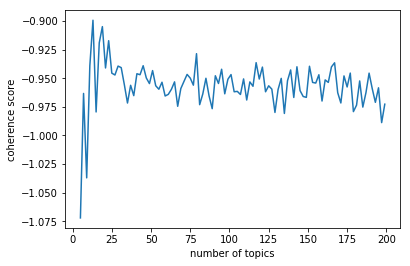

In [23]:
plt.plot(try_topic_n, [x for x in scores])
plt.xlabel('number of topics')
plt.ylabel('coherence score')

`numpy` has a handy `argmax` or `argmin` function that returns the index of the highest or lowest value in an array:

In [24]:
np.argmax(scores)

4

Then we can just index our topic numbers to get the corresponding number of topics with the highest coherency:

In [25]:
try_topic_n[np.argmax(scores)]

13

I've retrained the model for 13 topics and exported as below (note the `max_iter=1000` takes a long time, so I've pickled the model again):

---

```python
lda = LatentDirichletAllocation(n_components=13, max_iter=1000)
lda_model = lda.fit(dtm)

pickle.dump((lda, lda_model, dtm, cv), open('13-topics.pkl', 'wb'))
```

---

We can load in the pre-trained model from the `pickle`:

In [26]:
lda, lda_model, dtm, cv = pickle.load(open('scripts/13-topics.pkl', 'rb'))

Many papers in the social sciences still don't use a quantitative evaluation metric. Many use the library `pyLDAvis` to simply visualize the topic distributions, looking for the right size and little overlap in topics as markers of a well-chosen number of topics:

In [27]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, dtm, cv)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
12     13.440292        1       1 -0.023313 -0.104729
0      12.738078        1       2  0.052580 -0.090617
1      11.921893        1       3 -0.212336 -0.018731
8      11.692624        1       4 -0.070277 -0.041536
6      11.452392        1       5  0.149730  0.007720
5      10.549177        1       6  0.146266 -0.071886
3       7.119147        1       7 -0.022566  0.060951
10      7.064748        1       8  0.008804  0.106346
7       6.132170        1       9  0.093365  0.079750
11      4.225619        1      10  0.042795 -0.103414
9       2.853102        1      11 -0.255664  0.049772
2       0.810072        1      12  0.104300  0.141190
4       0.000687        1      13 -0.013683 -0.014816, topic_info=     Category         Freq       Term        Total  loglift  logprob
term                                                                
4525  Default  3208.000000       thou  3208.000000  30.0000  30.0000
4772  Default  5790.000000         ve  5790.000000  29.0000  29.0000
4512  Default  2486.000000       thee  2486.000000  28.0000  28.0000
4545  Default  2576.000000        thy  2576.000000  27.0000  27.0000
1272  Default  2667.000000       didn  2667.000000  26.0000  26.0000
323   Default  2289.000000       aunt  2289.000000  25.0000  25.0000
1367  Default  1624.000000     doctor  1624.000000  24.0000  24.0000
4989  Default  2145.000000         ye  2145.000000  23.0000  23.0000
2200  Default  2475.000000     honour  2475.000000  22.0000  22.0000
500   Default  1132.000000       boat  1132.000000  21.0000  21.0000
122   Default  1166.000000        ain  1166.000000  20.0000  20.0000
649   Default  1234.000000     castle  1234.000000  19.0000  19.0000
184   Default  1384.000000  apartment  1384.000000  18.0000  18.0000
4036  Default   784.000000       ship   784.000000  17.0000  17.0000
2480  Default  1605.000000        isn  1605.000000  16.0000  16.0000
4970  Default  1595.000000     wouldn  1595.000000  15.0000  15.0000
624   Default   739.000000    captain   739.000000  14.0000  14.0000
2729  Default  1016.000000      mamma  1016.000000  13.0000  13.0000
1483  Default  1375.000000         em  1375.000000  12.0000  12.0000
4959  Default  1044.000000      woods  1044.000000  11.0000  11.0000
2714  Default   473.000000     maiden   473.000000  10.0000  10.0000
4241  Default   928.000000     squire   928.000000   9.0000   9.0000
1008  Default  1310.000000     couldn  1310.000000   8.0000   8.0000
2000  Default   407.000000       gods   407.000000   7.0000   7.0000
2703  Default  1403.000000         ma  1403.000000   6.0000   6.0000
1372  Default  1007.000000      doesn  1007.000000   5.0000   5.0000
1363  Default   554.000000     divine   554.000000   4.0000   4.0000
2391  Default   887.000000   inquired   887.000000   3.0000   3.0000
1376  Default  1010.000000    dollars  1010.000000   2.0000   2.0000
3644  Default   485.000000   rejoined   485.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
4772  Topic13     0.001846         ve  5790.217849  -3.0708  -8.5172
2200  Topic13     0.001846     honour  2475.682550  -2.2211  -8.5172
1272  Topic13     0.001846       didn  2667.620084  -2.2958  -8.5172
4467  Topic13     0.001846        tea  2020.804523  -2.0181  -8.5172
323   Topic13     0.001846       aunt  2289.307547  -2.1429  -8.5172
4512  Topic13     0.001846       thee  2486.416197  -2.2255  -8.5172
4525  Topic13     0.001846       thou  3208.143474  -2.4803  -8.5172
1023  Topic13     0.001846     cousin  1757.788287  -1.8787  -8.5172
4545  Topic13     0.001846        thy  2576.348038  -2.2610  -8.5172
4989  Topic13     0.001846         ye  2145.519413  -2.0780  -8.5172
530   Topic13     0.001846       boys  1158.019732  -1.4613  -8.5172
2480  Topic13     0.001846        isn  1605.219104  -1.7879  -8.5172
3369  Topic13     0.001846  presently  131

### Topics

To `print` the topics, we can write a function. `display_topics` will print the most probable words to show up in each topic.

In [28]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(topic_idx, " ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

Now let's print the top 10 words of the 20 topics for the model we trained, using our `display_topics` function. Have a look through the output and see what topics you can spot:

In [29]:
display_topics(lda, dtm_feature_names, 10)

0 aunt mamma cousin sisters tea papa uncle widow pounds everybody
1 ve didn ain em wouldn ye dogs kitchen wheat couldn
2 maiden gods philosopher rejoined divine apartment statue marble inquired thy
3 ye honour king nation army squire government friar lad baron
4 ve honour didn tea aunt thee thou cousin thy ye
5 honour madam uncle ma wholly favour extremely begged behaviour coach
6 thy religion persons anguish apartment beheld principles passions sentiment respecting
7 castle woods mountains scout apartment chateau ma marquis concerning aunt
8 ve tea lad squire th margaret yo grey colour baby
9 ship boat captain doctor deck shore sail whilst vessel island
10 thou thee thy ye hath hast holy minister knight thine
11 laura neighbourhood doctor clerk interview interests boat evidence honour inquired
12 ve didn isn wouldn doesn couldn social haven dollars wasn


We can `print` which topic each novel is closest to by indexing the topic probabilities and using the `argmax` function:

In [30]:
doc_topic = lda.transform(dtm)

for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()
    print(metadata_tb['author'][n], metadata_tb['title'][n])
    print("doc: {} topic: {}\n".format(n,topic_most_pr))

Dreiser,Theodore SisterCarrie
doc: 0 topic: 12

Stowe,HarrietBeecher UncleTom'sCabin
doc: 1 topic: 1

Scott,Walter Ivanhoe
doc: 2 topic: 10

Crane,Stephen TheRedBadgeofCourage
doc: 3 topic: 1

Godwin,William CalebWilliams
doc: 4 topic: 6

Hardy,Thomas TessoftheD'Urbervilles
doc: 5 topic: 8

Child,Lydia Philothea
doc: 6 topic: 2

Braddon,Mary TheGoldenCalf
doc: 7 topic: 0

Alcott,Louisa LittleWomen
doc: 8 topic: 0

Dickens,Charles GreatExpectations
doc: 9 topic: 1

Lawrence,D.H. SonsandLovers
doc: 10 topic: 1

Bronte,Ann TheTenantofWildfellHall
doc: 11 topic: 0

Eliot,George Romola
doc: 12 topic: 10

Aguilar,Grace ValeofCedars
doc: 13 topic: 10

Yonge,Charlotte TheHeirofRedcliffe
doc: 14 topic: 0

Cooper,JamesFenimore ThePioneers
doc: 15 topic: 3

Trollope,Anthony PhineasFinn
doc: 16 topic: 0

Stevenson,RobertLouis JekyllandHyde
doc: 17 topic: 9

Borrow,George TheBibleinSpain
doc: 18 topic: 3

Wollstonecraft,Mary Maria
doc: 19 topic: 6

Norris,Frank ThePit
doc: 20 topic: 1

Craik,Dinah 

To get the probabilities for each topic for a given book we can print the whole probability list for a given novel:

In [31]:
metadata_tb['author'][25], metadata_tb['title'][25], doc_topic[25]

('Edgeworth,Maria',
 'Leonora',
 array([  1.63855409e-01,   1.19987718e-05,   7.96414969e-03,
          1.14255336e-02,   1.19986082e-05,   3.95844424e-01,
          3.90338234e-01,   1.26144617e-02,   1.19988124e-05,
          1.19988548e-05,   1.36693857e-02,   1.19988142e-05,
          4.22840900e-03]))

### Challenge

Add these topic assignments back to our `Table` `metadata_tb`

In [32]:
# YOUR CODE HERE

## Interpreting the Model

There are many strategies that can be used to interpret the output of a topic model. In this case, we will look for any correlations between the topic distributions and metadata.

We'll first grab all the topic distributions similar to what we did above. Remember, the order of the novels is still the same!

In [33]:
list_of_doctopics = [doc_topic[n] for n in range(len(doc_topic))]
list_of_doctopics[0]

array([  3.74263196e-03,   2.41587636e-01,   5.86537101e-06,
         5.86538222e-06,   5.86527464e-06,   3.66496255e-02,
         2.68368745e-02,   5.86538173e-06,   5.86538193e-06,
         5.86538412e-06,   8.79970468e-04,   5.86538090e-06,
         6.90262204e-01])

We'll make a `DataFrame`, which is similar to a `Table`, with the probabilities for the topics (columns) and documents (rows):

In [34]:
df = pd.DataFrame(list_of_doctopics)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.003743,0.241588,0.000006,0.000006,0.000006,0.036650,0.026837,0.000006,0.000006,0.000006,0.000880,0.000006,0.690262
1,0.161628,0.530295,0.000004,0.029890,0.000004,0.000004,0.103822,0.000004,0.026528,0.004156,0.130962,0.000004,0.012698
2,0.000003,0.000003,0.000003,0.181354,0.000003,0.035976,0.031576,0.061129,0.000003,0.000003,0.689937,0.000003,0.000003
3,0.000014,0.719892,0.000014,0.021756,0.000014,0.000014,0.052180,0.152988,0.049613,0.000014,0.000014,0.000014,0.003472
4,0.000005,0.000005,0.000005,0.104593,0.000005,0.167195,0.726078,0.000005,0.000005,0.002090,0.000005,0.000005,0.000005


We can add these columns to our `metadata_tb` `Table`:

In [35]:
meta = metadata_tb.to_df()
meta[df.columns] = df
meta.head()

,filename,id,language,date,author,title,gender,person,length,0,...,3,4,5,6,7,8,9,10,11,12
0,"EN_1900_Dreiser,Theodore_SisterCarrie_Novel.txt",265,English,1900,"Dreiser,Theodore",SisterCarrie,male,third,156048,0.003743,...,0.000006,0.000006,0.036650,0.026837,0.000006,0.000006,0.000006,0.000880,0.000006,0.690262
1,"EN_1853_Stowe,HarrietBeecher_UncleTom'sCabin_N...",213,English,1853,"Stowe,HarrietBeecher",UncleTom'sCabin,female,third,180498,0.161628,...,0.029890,0.000004,0.000004,0.103822,0.000004,0.026528,0.004156,0.130962,0.000004,0.012698
2,"EN_1820_Scott,Walter_Ivanhoe_Novel.txt",184,English,1820,"Scott,Walter",Ivanhoe,male,third,175069,0.000003,...,0.181354,0.000003,0.035976,0.031576,0.061129,0.000003,0.000003,0.689937,0.000003,0.000003
3,"EN_1895_Crane,Stephen_TheRedBadgeofCourage_Nov...",258,English,1895,"Crane,Stephen",TheRedBadgeofCourage,male,third,46049,0.000014,...,0.021756,0.000014,0.000014,0.052180,0.152988,0.049613,0.000014,0.000014,0.000014,0.003472
4,"EN_1794_Godwin,William_CalebWilliams_Novel.txt",158,English,1794,"Godwin,William",CalebWilliams,male,first,143832,0.000005,...,0.104593,0.000005,0.167195,0.726078,0.000005,0.000005,0.002090,0.000005,0.000005,0.000005


The `corr()` method will give us a correlation matrix:

In [36]:
meta.corr()

,id,date,length,0,1,2,3,4,5,6,7,8,9,10,11,12
id,1.000000,0.989293,-0.160204,-0.152434,0.572221,-0.078462,-0.291158,0.177250,-0.508749,-0.516003,-0.302783,0.283322,0.182507,-0.108731,0.009553,0.546103
date,0.989293,1.000000,-0.131386,-0.109032,0.538569,-0.060252,-0.304192,0.155241,-0.555964,-0.532168,-0.309598,0.308496,0.205571,-0.081166,0.039784,0.536713
length,-0.160204,-0.131386,1.000000,0.263755,-0.244553,-0.062703,-0.042924,-0.743355,0.275029,-0.164554,0.018215,0.062639,-0.207433,-0.009373,0.144859,0.021067
0,-0.152434,-0.109032,0.263755,1.000000,-0.181405,-0.057494,-0.068135,-0.131120,0.053067,-0.132030,-0.188447,-0.035257,-0.189187,-0.135976,-0.050185,-0.134841
1,0.572221,0.538569,-0.244553,-0.181405,1.000000,-0.068212,-0.180374,0.329774,-0.259983,-0.295489,-0.133439,-0.052223,-0.018205,-0.153772,-0.122199,-0.025223
2,-0.078462,-0.060252,-0.062703,-0.057494,-0.068212,1.000000,-0.039680,-0.025743,-0.043849,-0.048615,-0.034832,-0.066170,-0.038329,-0.033162,-0.013116,-0.064700
3,-0.291158,-0.304192,-0.042924,-0.068135,-0.180374,-0.039680,1.000000,0.047297,-0.036884,-0.078284,0.068400,-0.165410,-0.047984,0.035017,-0.061852,-0.171921
4,0.177250,0.155241,-0.743355,-0.131120,0.329774,-0.025743,0.047297,1.000000,-0.168267,-0.008754,-0.075140,-0.047680,0.170442,-0.104526,-0.079231,-0.027975
5,-0.508749,-0.555964,0.275029,0.053067,-0.259983,-0.043849,-0.036884,-0.168267,1.000000,0.108961,-0.028937,-0.199106,-0.151135,-0.130868,-0.103558,-0.211949
6,-0.516003,-0.532168,-0.164554,-0.132030,-0.295489,-0.048615,-0.078284,-0.008754,0.108961,1.000000,0.051374,-0.223339,-0.108129,-0.034809,-0.058271,-0.243017


We see some strong correlations of topics with `date`, recall:

In [37]:
display_topics(lda, dtm_feature_names, 10)

0 aunt mamma cousin sisters tea papa uncle widow pounds everybody
1 ve didn ain em wouldn ye dogs kitchen wheat couldn
2 maiden gods philosopher rejoined divine apartment statue marble inquired thy
3 ye honour king nation army squire government friar lad baron
4 ve honour didn tea aunt thee thou cousin thy ye
5 honour madam uncle ma wholly favour extremely begged behaviour coach
6 thy religion persons anguish apartment beheld principles passions sentiment respecting
7 castle woods mountains scout apartment chateau ma marquis concerning aunt
8 ve tea lad squire th margaret yo grey colour baby
9 ship boat captain doctor deck shore sail whilst vessel island
10 thou thee thy ye hath hast holy minister knight thine
11 laura neighbourhood doctor clerk interview interests boat evidence honour inquired
12 ve didn isn wouldn doesn couldn social haven dollars wasn


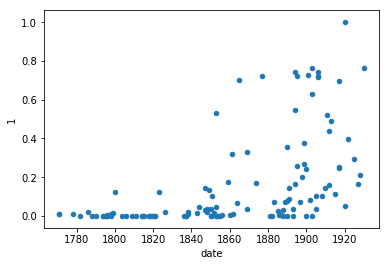

In [38]:
meta.plot.scatter(x='date', y=1)

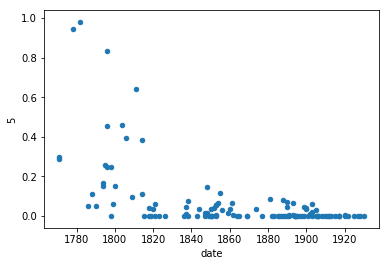

In [39]:
meta.plot.scatter(x='date', y=5)

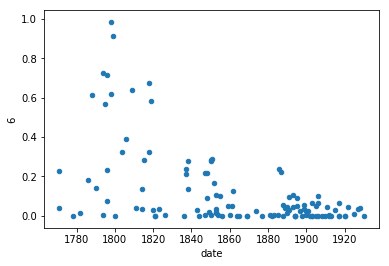

In [40]:
meta.plot.scatter(x='date', y=6)

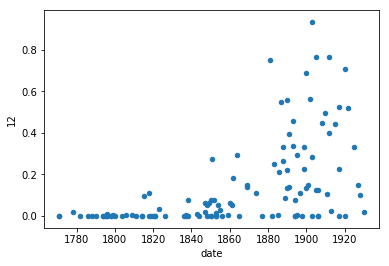

In [41]:
meta.plot.scatter(x='date', y=12)

Why do you think we see this?

# Homework

We're going to download the [20 Newsgroups](http://qwone.com/~jason/20Newsgroups/), a widely used corpus for demos of general texts:

> The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. To the best of my knowledge, it was originally collected by Ken Lang, probably for his Newsweeder: Learning to filter netnews paper, though he does not explicitly mention this collection. The 20 newsgroups collection has become a popular data set for experiments in text applications of machine learning techniques, such as text classification and text clustering.

Let's read in the training data:

In [2]:
train_subset = pickle.load(open('scripts/20-news-train.pkl', 'rb'))

Here are the predetermined catgories:

In [3]:
train_subset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Since we're topic modeling, we don't care about what they've been labeled, but it'll be interesting to see how our topics line up with these!

How many documents are there?

In [4]:
len(train_subset.data)

11314

Let's get a list of documents as strings just like we did with the novels, and then we'll randomly shuffle them in case they're ordered by category already:

In [5]:
documents_train = train_subset.data
np.random.shuffle(documents_train)

In [6]:
print(documents_train[0])

From: tim@kimba.catt.citri.edu.au (Tim Liddelow)
Subject: Keysym database problems
Keywords: X, Motif
Organization: CATT Centre at CITRI, Melbourne, Australia
Lines: 31

I am having problems with a  Motif application that when run on another machine
(with different X paths, etc) can't find the XKeysymDB file.   This causes a large
warning output:

...
....
....
etc.

as the file is in a different location, but Xt seems to only look for it in
the place where it is on the machine the app was compiled on.  Is there any
way to read the XKeysymDB manually with an X/Xt call so that additions to
the XKeysymDB can be distributed with the application ?  I have used trace(1)
to find out what was going on, but I need a fix so that these translations in
the application can be recognised.

--tim
________________________________________________________________________________
  Tim Liddelow                                          for(;;) fork();
  Systems Programmer
  Centre of Advanced Technology 

Now we'll do the same for the test set:

In [7]:
test_subset = pickle.load(open('scripts/20-news-test.pkl', 'rb'))
documents_test = test_subset.data
np.random.shuffle(documents_test)
print(documents_test[0])

From: bill@twg.bc.ca (Bill Irwin)
Subject: Re: What WAS the immaculate conception
Reply-To: bill@twg.bc.ca (Bill Irwin)
Organization: The Westrheim Group (TWG)
Lines: 53

ragraca@vela.acs.oakland.edu (Randy A. Graca) writes:

:                                                               Consequently,
: this verse indicates that she was without sin.  Also, as was observed at
: the very top of this post, Mary had to be free from sin in order to be the
: mother of Jesus, who was definitely without sin.

If the mother of Jesus had to be without sin in order to give
birth to God, then why didn't Mary's mother have to be without
sin in order to give birth to the perfect vessel for Jesus?  For
that matter, why didn't Mary's grandmother have to be without sin
either?  Seems to me that with all the original sin flowing
through each person, the need for the last one (Mary) to have
none puts God in a box, where we say that He couldn't have
incarnated Himself through a normal human being.

My Go

## TASK:

You now have two arrays of strings: `documents_train` and `documents_test`. Create a `dtm` and then a topic model for `k` number of topics. Just choose one number of `k` and a very low `iter` value for the training so it doesn't take too long. 

See how the topics match up to the annotated categories, and play with different ways of preprocessing the data. Use the `pyLDAvis` library to evaluate your model.

What did you have to do to get decent results?

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=500, stop_words='english', max_df=0.5, min_df=5)
dtm_trained = cv.fit_transform(documents_train)
desparse = dtm_trained.toarray()
words = cv.get_feature_names()
dtm_trained_tb = Table(words).with_rows(desparse)
dtm_trained_tb

00,000,0d,0t,10,100,11,12,13,14,145,15,16,17,18,19,1993,1d9,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,34u,35,40,45,50,55,80,92,93,__,___,a86,able,ac,access,actually,address,ago,agree,al,american,andrew,answer,anybody,apple,application,apr,april,area,argument,armenian,armenians,article,ask,asked,att,au,available,away,ax,b8f,bad,based,believe,berkeley,best,better,bible,big,bike,bit,black,board,body,book,box,buy,ca,california,called,came,canada,car,card,care,case,cause,cc,center,certain,certainly,change,check,children,chip,christ,christian,christians,church,city,claim,clinton,clipper,cmu,code,college,color,colorado,columbia,com,come,comes,comp,company,computer,consider,contact,control,copy,correct,cost,country,couple,course,cs,current,cwru,data,dave,david,day,days,db,deal,death,department,dept,did,didn,difference,different,disk,display,distribution,division,dod,does,doesn,doing,don,dos,drive,driver,drivers,earth,email,encryption,end,engineering,especially,evidence,exactly,example,experience,fact,faith,faq,far,fast,fax,feel,file,files,following,free,ftp,g9v,game,games,general,getting,given,gmt,god,going,good,got,gov,government,graphics,great,group,groups,guess,gun,guns,hand,hard,hardware,having,head,health,heard,hell,help,hi,high,history,hockey,home,hope,host,house,hp,human,ibm,idea,image,important,include,including,info,information,instead,institute,interested,internet,isn,israel,israeli,issue,james,jesus,jewish,jews,jim,john,just,keith,key,keys,keywords,killed,kind,know,known,large,later,law,left,let,level,life,like,likely,line,list,little,live,ll,local,long,look,looking,lot,love,low,ma,mac,machine,mail,major,make,makes,making,man,mark,matter,max,maybe,mean,means,memory,men,message,michael,mike,mind,mit,money,mr,ms,na,nasa,national,need,net,netcom,network,new,news,newsreader,nice,nntp,non,note,number,numbers,office,oh,ohio,ok,old,open,opinions,order,org,original,output,package,paul,pay,pc,people,period,person,phone,pitt,pl,place,play,players,point,points,police,possible,post,posting,power,president,press,pretty,price,private,probably,problem,problems,program,programs,provide,pub,public,question,questions,quite,read,reading,real,really,reason,religion,remember,reply,research,right,rights,robert,run,running,said,sale,san,saw,say,saying,says,school,science,screen,scsi,season,second,security,seen,send,sense,server,service,services,set,similar,simple,simply,single,size,small,software,sorry,sort,sound,source,space,speed,st,standard,start,started,state,states,steve,stop,stuff,summary,sun,support,sure,systems,talk,talking,team,technology,tell,test,text,thanks,thing,things,think,thought,time,times,today,told,took,toronto,tried,true,truth,try,trying,turkish,type,uiuc,uk,understand,university,unix,unless,usa,use,used,user,using,usually,uucp,ve,version,video,view,virginia,vs,want,wanted,war,washington,way,week,went,white,win,window,windows,won,word,words,work,working,works,world,wouldn,write,wrong,wrote,year,years,yes,york
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,

In [9]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=19, max_iter=5)
np.random.seed(0)
model = lda.fit(dtm_trained)
model.perplexity(cv.transform(documents_test))

/srv/app/venv/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:532: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


337.16441475360034

In [10]:
dtm_test = cv.fit_transform(documents_test)
desp = dtm_test.toarray()
word = cv.get_feature_names()
dtm_test_tb = Table(word).with_rows(desp)
dtm_test_tb

00,000,10,100,11,12,13,14,15,16,17,18,19,1993,20,21,22,23,24,25,26,27,28,29,30,31,32,33,40,50,80,92,93,__,able,ac,access,according,actually,add,address,ago,agree,american,andrew,answer,anybody,apple,apr,april,area,armenian,armenians,article,ask,asked,att,au,available,away,bad,based,batf,believe,best,better,bible,big,bit,black,blue,board,body,book,books,box,brian,buffalo,buy,ca,california,called,came,canada,car,card,care,case,cause,cc,center,certainly,change,check,children,chip,christ,christian,christians,church,claim,clear,clinton,clipper,cmu,code,college,color,colorado,com,come,comes,common,comp,company,computer,control,copy,cost,country,couple,course,cs,cso,current,data,dave,david,day,days,dead,death,department,dept,did,didn,difference,different,discussion,disk,display,distribution,does,doesn,doing,don,dos,drive,earth,ed,effect,email,end,engineering,especially,evidence,example,fact,faith,faq,far,fax,fbi,feel,file,files,fine,following,force,form,format,free,ftp,game,games,general,getting,gif,given,gmt,god,goes,going,good,got,gov,government,graphics,great,group,guess,gun,guy,hand,happened,hard,hardware,haven,having,head,health,heard,hell,help,hi,high,history,hit,home,homosexuality,hope,host,house,hp,human,ibm,idea,ii,image,images,important,include,including,info,information,instead,institute,interested,interesting,internet,isn,israel,issue,james,jesus,jewish,jews,jim,john,jpeg,just,key,keywords,killed,kind,know,known,koresh,large,later,law,left,let,life,light,like,line,list,little,live,ll,local,long,look,looking,lord,lot,love,low,ma,mac,machine,mail,major,make,makes,making,man,mark,matter,maybe,mean,means,medical,memory,men,message,michael,microsoft,mike,mind,mit,money,monitor,months,mr,ms,muslim,muslims,nasa,national,need,net,netcom,network,new,news,newsreader,nice,night,nntp,non,note,number,oh,ohio,ok,old,open,opinion,opinions,order,org,original,os,past,paul,pc,peace,people,performance,person,personal,peter,phone,place,play,point,police,position,possible,post,posting,power,president,press,pretty,price,private,probably,problem,problems,program,programs,public,quality,question,questions,quite,read,reading,real,really,reason,red,religion,religious,remember,reply,research,rest,right,rights,robert,run,running,said,sale,san,saw,say,saying,says,school,science,scott,screen,scsi,second,seen,self,send,sense,series,server,service,services,set,similar,simple,simply,sin,single,situation,small,software,sorry,sort,sound,source,space,speed,st,standard,stanford,start,started,state,statement,states,steve,stop,stratus,study,stuff,summary,sun,support,sure,systems,talk,team,technology,tell,test,text,thanks,thing,things,think,thought,time,times,tin,today,told,toronto,tried,true,try,trying,type,uiuc,uk,understand,university,unix,unless,usa,use,used,usenet,user,users,using,uucp,ve,version,video,view,virginia,vs,waco,want,wanted,war,washington,way,went,western,white,win,window,windows,women,won,word,words,work,working,works,world,wouldn,write,written,wrong,wrote,year,years,yes
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3,0,4,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,

In [11]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, dtm_test, cv)
#there was too much overlap for this model to be good :(

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
14     24.388867        1       1 -0.197419 -0.037499
18     10.784144        1       2 -0.154599  0.037140
5       7.043963        1       3 -0.141889 -0.071628
0       6.378410        1       4 -0.023105 -0.118538
16      5.009465        1       5 -0.048453 -0.097343
8       4.879413        1       6 -0.180480 -0.117946
7       4.612666        1       7  0.212563  0.245436
17      4.106497        1       8 -0.103627  0.050589
6       4.045635        1       9 -0.082628 -0.144019
11      3.745858        1      10 -0.002051  0.091877
9       3.551317        1      11 -0.105734  0.092932
10      3.418072        1      12 -0.078512  0.098149
1       3.277542        1      13 -0.129885  0.050016
2       3.267350        1      14  0.199812  0.188663
3       3.242137        1      15  0.181044  0.193764
13      3.196521        1      16 -0.028757 -0.061249
12      3.190985        1      17  0.016122  0.052694
15      1.360487        1      18  0.364922 -0.215947
4       0.500668        1      19  0.302678 -0.237092, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
72    Default  4206.000000          body  4206.000000  30.0000  30.0000
122   Default  7825.000000            cs  7825.000000  29.0000  29.0000
456   Default  1753.000000          unix  1753.000000  28.0000  28.0000
164   Default  1491.000000          file  1491.000000  27.0000  27.0000
46    Default  1422.000000       anybody  1422.000000  26.0000  26.0000
216   Default   859.000000          idea   859.000000  25.0000  25.0000
0     Default  1470.000000            00  1470.000000  24.0000  24.0000
184   Default  1573.000000           got  1573.000000  23.0000  23.0000
350   Default  2178.000000       problem  2178.000000  22.0000  22.0000
252   Default  1295.000000           let  1295.000000  21.0000  21.0000
224   Default  1922.000000   information  1922.000000  20.0000  20.0000
105   Default   758.000000          code   758.000000  19.0000  19.0000
316   Default  1845.000000            ok  1845.000000  18.0000  18.0000
90    Default  2099.000000        center  2099.000000  17.0000  17.0000
228   Default  1051.000000   interesting  1051.000000  16.0000  16.0000
458   Default  2912.000000           usa  2912.000000  15.0000  15.0000
414   Default  1027.000000      stanford  1027.000000  14.0000  14.0000
335   Default   998.000000         place   998.000000  13.0000  13.0000
336   Default  4178.000000          play  4178.000000  12.0000  12.0000
310   Default   964.000000          nntp   964.000000  11.0000  11.0000
65    Default  4591.000000        better  4591.000000  10.0000  10.0000
201   Default  1425.000000         heard  1425.000000   9.0000   9.0000
137   Default  1270.000000     different  1270.000000   8.0000   8.0000
360   Default  1255.000000       reading  1255.000000   7.0000   7.0000
196   Default  2146.000000      hardware  2146.000000   6.0000   6.0000
4     Default  1748.000000            11  1748.000000   5.0000   5.0000
145   Default   855.000000           don   855.000000   4.0000   4.0000
383   Default   840.000000        school   840.000000   3.0000   3.0000
422   Default   829.000000       stratus   829.000000   2.0000   2.0000
107   Default   887.000000         color   887.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
264   Topic19     0.068063       looking   229.599908  -2.8267 -10.2116
158   Topic19     0.068063         faith   232.480548  -2.8392 -10.2116
116   Topic19     0.068063       control   240.316528  -2.8723 -10.2116
42    Topic19     0.068063         agree   244.969358  -2.8915 -10.2116
82    Topic19     0.068063          came   254.136327  -2.9282 -10.2116
447   Topic19     0.068063         tried   256.547448  -2.9377 -10.2116
141   Topic19  

In [12]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(topic_idx, " ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [13]:
display_topics(lda, word, 5)
#grouped all the numbers together, didn't seem to line up with preestablished topics based on the visualization

0 got reading gov user great
1 cs women problem information ok
2 unix anybody way files add
3 00 interesting place don school
4 idea code mit vs 15
5 claim local play heard key
6 let color form computer heard
7 11 22 19 away 18
8 hit religion fbi thought netcom
9 different usa better problem information
10 problem information ok center usa
11 file sense black uk believe
12 cs nntp stratus couple science
13 stanford news health said clear
14 play hardware fbi list law
15 body mit book andrew group
16 windows christ need isn canada
17 center technology guess wrote power
18 cs better chip lot fbi


In [14]:
#2nd trial, changed max_df from 0.5 to 0.8
cv2 = CountVectorizer(max_features=500, stop_words='english', max_df=0.8, min_df=5)
dtm_trained2 = cv2.fit_transform(documents_train)
desparse2 = dtm_trained2.toarray()
words2 = cv2.get_feature_names()
dtm_trained_tb2 = Table(words2).with_rows(desparse2)
dtm_trained_tb2

00,000,0d,0t,10,100,11,12,13,14,145,15,16,17,18,19,1993,1d9,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,34u,35,40,45,50,55,80,92,93,__,___,a86,able,ac,access,actually,address,ago,agree,al,american,andrew,answer,anybody,apple,application,apr,april,area,argument,armenian,armenians,article,ask,asked,att,au,available,away,ax,b8f,bad,based,believe,berkeley,best,better,bible,big,bike,bit,black,board,body,book,box,buy,ca,california,called,came,canada,car,card,care,case,cause,cc,center,certain,certainly,change,check,children,chip,christ,christian,christians,church,city,claim,clinton,clipper,cmu,code,college,color,colorado,columbia,com,come,comes,comp,company,computer,consider,contact,control,copy,correct,cost,country,couple,course,cs,current,cwru,data,dave,david,day,days,db,deal,death,department,dept,did,didn,difference,different,disk,display,distribution,division,dod,does,doesn,doing,don,dos,drive,driver,drivers,earth,edu,email,encryption,end,engineering,especially,evidence,exactly,example,experience,fact,faith,faq,far,fast,fax,feel,file,files,following,free,ftp,g9v,game,games,general,getting,given,gmt,god,going,good,got,gov,government,graphics,great,group,groups,guess,gun,guns,hand,hard,hardware,having,head,health,heard,hell,help,hi,high,history,hockey,home,hope,host,house,hp,human,ibm,idea,image,important,include,including,info,information,instead,institute,interested,internet,isn,israel,israeli,issue,james,jesus,jewish,jews,jim,john,just,keith,key,keys,keywords,killed,kind,know,known,large,later,law,left,let,level,life,like,likely,line,list,little,live,ll,local,long,look,looking,lot,love,low,ma,mac,machine,mail,major,make,makes,making,man,mark,matter,max,maybe,mean,means,memory,men,message,michael,mike,mind,mit,money,mr,ms,na,nasa,national,need,net,netcom,network,new,news,newsreader,nice,nntp,non,note,number,numbers,office,oh,ohio,old,open,opinions,order,org,original,output,package,paul,pay,pc,people,period,person,phone,pitt,pl,place,play,players,point,points,police,possible,post,posting,power,president,press,pretty,price,private,probably,problem,problems,program,programs,provide,pub,public,question,questions,quite,read,reading,real,really,reason,religion,remember,reply,research,right,rights,robert,run,running,said,sale,san,saw,say,saying,says,school,science,screen,scsi,season,second,security,seen,send,sense,server,service,services,set,similar,simple,simply,single,size,small,software,sorry,sort,sound,source,space,speed,st,standard,start,started,state,states,steve,stop,stuff,summary,sun,support,sure,systems,talk,talking,team,technology,tell,test,text,thanks,thing,things,think,thought,time,times,today,told,took,toronto,tried,true,truth,try,trying,turkish,type,uiuc,uk,understand,university,unix,unless,usa,use,used,user,using,usually,uucp,ve,version,video,view,virginia,vs,want,wanted,war,washington,way,went,white,win,window,windows,won,word,words,work,working,works,world,wouldn,write,writes,wrong,wrote,year,years,yes,york
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0

In [15]:
lda2 = LatentDirichletAllocation(n_components=19, max_iter=5)
np.random.seed(1)
model2 = lda2.fit(dtm_trained2)
model2.perplexity(cv2.transform(documents_test))
dtm_test2 = cv2.fit_transform(documents_test)
desp2 = dtm_test2.toarray()
word3 = cv2.get_feature_names()
dtm_test_tb2 = Table(word3).with_rows(desp2)
dtm_test_tb2

/srv/app/venv/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:532: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


00,000,10,100,11,12,13,14,15,16,17,18,19,1993,20,21,22,23,24,25,26,27,28,29,30,31,32,33,40,50,80,92,93,__,able,ac,access,according,actually,add,address,ago,agree,american,andrew,answer,anybody,apple,apr,april,area,armenian,armenians,article,ask,asked,att,au,available,away,bad,based,batf,believe,best,better,bible,big,bit,black,blue,board,body,book,books,box,brian,buffalo,buy,ca,california,called,came,canada,car,card,care,case,cause,cc,center,certainly,change,check,children,chip,christ,christian,christians,church,claim,clear,clinton,clipper,cmu,code,college,color,colorado,com,come,comes,common,comp,company,computer,control,copy,cost,country,couple,course,cs,cso,current,data,dave,david,day,days,dead,death,department,dept,did,didn,difference,different,discussion,disk,display,distribution,does,doesn,doing,don,dos,drive,earth,ed,edu,effect,email,end,engineering,especially,evidence,example,fact,faith,faq,far,fax,fbi,feel,file,files,fine,following,force,form,format,free,ftp,game,games,general,getting,gif,given,gmt,god,goes,going,good,got,gov,government,graphics,great,group,guess,gun,guy,hand,happened,hard,hardware,haven,having,head,health,heard,hell,help,hi,high,history,hit,home,homosexuality,hope,host,house,hp,human,ibm,idea,ii,image,images,important,include,including,info,information,instead,institute,interested,interesting,internet,isn,israel,issue,james,jesus,jewish,jews,jim,john,jpeg,just,key,keywords,killed,kind,know,known,koresh,large,later,law,left,let,life,light,like,line,list,little,live,ll,local,long,look,looking,lord,lot,love,low,ma,mac,machine,mail,major,make,makes,making,man,mark,matter,maybe,mean,means,medical,memory,men,message,michael,microsoft,mike,mind,mit,money,monitor,months,mr,ms,muslim,muslims,nasa,national,need,net,netcom,network,new,news,newsreader,nice,night,nntp,non,note,number,oh,ohio,ok,old,open,opinion,opinions,order,org,original,os,past,paul,pc,peace,people,person,personal,peter,phone,place,play,point,police,position,possible,post,posting,power,president,press,pretty,price,private,probably,problem,problems,program,programs,public,quality,question,questions,quite,read,reading,real,really,reason,red,religion,religious,remember,reply,research,rest,right,rights,robert,run,running,said,sale,san,saw,say,saying,says,school,science,scott,screen,scsi,second,seen,self,send,sense,series,server,service,services,set,similar,simple,simply,sin,single,situation,small,software,sorry,sort,sound,source,space,speed,st,standard,start,started,state,statement,states,steve,stop,stratus,study,stuff,summary,sun,support,sure,systems,talk,team,technology,tell,test,text,thanks,thing,things,think,thought,time,times,tin,today,told,toronto,tried,true,try,trying,type,uiuc,uk,understand,university,unix,unless,usa,use,used,usenet,user,users,using,uucp,ve,version,video,view,virginia,vs,waco,want,wanted,war,washington,way,went,western,white,win,window,windows,women,won,word,words,work,working,works,world,wouldn,write,writes,written,wrong,wrote,year,years,yes
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3,0,4,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0


In [17]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda2, dtm_test2, cv2)
#somehow even more overlap in this model even though i changed the max_df to 0.8; conclusion: first way generated a better topic model

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
5      16.782609        1       1 -0.193970 -0.023657
0      16.034799        1       2 -0.200995 -0.005495
4      13.606043        1       3 -0.182250 -0.024942
2       7.675359        1       4  0.017520  0.014417
14      6.376634        1       5  0.205349  0.170674
8       5.473826        1       6 -0.030206 -0.185841
11      4.590489        1       7  0.043221 -0.165725
7       3.382021        1       8  0.014932 -0.115656
9       3.158577        1       9 -0.132756  0.185839
6       3.116822        1      10 -0.026638  0.164259
13      2.846335        1      11  0.040715 -0.166584
10      2.502025        1      12 -0.007155 -0.077121
18      2.345717        1      13 -0.132451 -0.030249
12      2.309536        1      14  0.024544  0.159348
15      2.263531        1      15  0.003014  0.138792
17      2.178943        1      16  0.185223 -0.229168
16      1.958298        1      17 -0.010057 -0.028648
1       1.754151        1      18  0.412086  0.075660
3       1.644284        1      19 -0.030125  0.144098, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
72    Default  5644.000000        body  5644.000000  30.0000  30.0000
168   Default  6410.000000   following  6410.000000  29.0000  29.0000
122   Default  4449.000000          cs  4449.000000  28.0000  28.0000
90    Default  1911.000000      center  1911.000000  27.0000  27.0000
197   Default  3174.000000    hardware  3174.000000  26.0000  26.0000
420   Default  1634.000000        stop  1634.000000  25.0000  25.0000
336   Default  5568.000000        play  5568.000000  24.0000  24.0000
458   Default  2322.000000         use  2322.000000  23.0000  23.0000
185   Default  1210.000000         got  1210.000000  22.0000  22.0000
253   Default  1441.000000         let  1441.000000  21.0000  21.0000
493   Default  2799.000000      writes  2799.000000  20.0000  20.0000
358   Default  1732.000000       quite  1732.000000  19.0000  19.0000
483   Default  1154.000000       women  1154.000000  18.0000  18.0000
164   Default  1020.000000        feel  1020.000000  17.0000  17.0000
462   Default  2832.000000       users  2832.000000  16.0000  16.0000
376   Default  1126.000000        said  1126.000000  15.0000  15.0000
65    Default  2588.000000      better  2588.000000  14.0000  14.0000
202   Default  2000.000000       heard  2000.000000  13.0000  13.0000
414   Default   941.000000       start   941.000000  12.0000  12.0000
95    Default  1040.000000        chip  1040.000000  11.0000  11.0000
313   Default  2741.000000        note  2741.000000  10.0000  10.0000
0     Default  1174.000000          00  1174.000000   9.0000   9.0000
456   Default   821.000000      unless   821.000000   8.0000   8.0000
262   Default  1036.000000       local  1036.000000   7.0000   7.0000
101   Default  1006.000000       clear  1006.000000   6.0000   6.0000
426   Default   959.000000     support   959.000000   5.0000   5.0000
392   Default   694.000000       sense   694.000000   4.0000   4.0000
477   Default   789.000000        went   789.000000   3.0000   3.0000
4     Default  1726.000000          11  1726.000000   2.0000   2.0000
350   Default  1835.000000     problem  1835.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
458   Topic19   397.166958         use  2322.127853   2.3420  -2.7796
313   Topic19   324.509801        note  2741.658167   1.9739  -2.9817
334   Topic19    43.703743       phone   392.733450   1.9122  -4.9865
182   Topic19    40.414129        goes   373.659674   1.8837  -5.0648
149   Topic19    25.520362          ed   254.200824   1.8092  -5.5245
133   Topic19    32.463560        dept   378.823113   1.6509  -5.2839
287   Topic19    39.522042     message   565.196164   1.4476  -5.0871
328   Topic19    48.269

In [18]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(topic_idx, " ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
display_topics(lda, word, 5)
#grouped all the numbers together, didn't seem to line up with preestablished topics based on the visualization

0 got reading gov user great
1 cs women problem information ok
2 unix anybody way files add
3 00 interesting place don school
4 idea code mit vs 15
5 claim local play heard key
6 let color form computer heard
7 11 22 19 away 18
8 hit religion fbi thought netcom
9 different usa better problem information
10 problem information ok center usa
11 file sense black uk believe
12 cs nntp stratus couple science
13 stanford news health said clear
14 play hardware fbi list law
15 body mit book andrew group
16 windows christ need isn canada
17 center technology guess wrote power
18 cs better chip lot fbi


# BONUS (not assigned)

Create a classifier from this corpus. They're assigned group are in the `target` attribute:

In [ ]:
train_subset.target

In [ ]:
test_subset.target